0 1
1 12
2 60
3 162
4 255
5 234
6 116
7 24


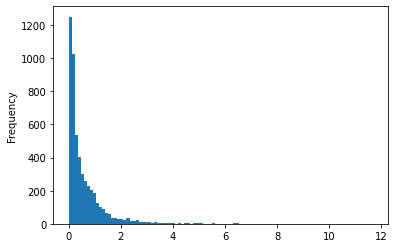

In [62]:
#Generate sequences for all mutations in deep mutational scan covid spike RBD experiment 
#! pip install Bio
import pandas as pd
import Bio
from Bio import SeqIO
from Bio import SeqRecord
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from Bio.Seq import MutableSeq
import numpy as np
#import tabulate

# read and get fitness
file = '../data/NA_compile_results.tsv'
df = pd.read_csv(file, sep="\t") 

plt.figure()
df['fit'].plot.hist(bins=100)
#print(min(df['fit']), max(df['fit']))

# pick a single strain background, since landscapes are highly correlated among the strains
df = df[df['strain'] == 'HK19']
#print(df)
recs = df.to_dict('records')
#print(recs)
wt = 'KSENETS' # HK19 seq

# calculate Hamming distances
def aa_dist(wt, hap):
    d = 0;
    for i in range(len(wt)):
        if wt[i] != hap[i]:
            d += 1
    return(d)

#print(aa_dist(wt, 'NDEGEEL'))

wtDict = {}
for rec in recs:
    wtDict[rec['ID']] = {'fit': rec['fit'], 'charge': rec['charge'], 'subset': aa_dist(wt, rec['ID'])}
#print(wtDict)
for level in range(8):
    ndPre = [id for id in  wtDict if wtDict[id]['subset'] == level]
    print(level, len(ndPre))

In [51]:
# build a directed graph
import networkx as nx

DG = nx.DiGraph() # a directed graph, there is lots of graph algorithms to identify local and global peaks; apply evol algo

# add nodes
for id in wtDict: 
    DG.add_node(id) # add a node with a string name (id)        
    for k in wtDict[id]: # attach features: fit, charge, subset 
        DG.nodes[id][k] = wtDict[id][k]

for level in range(8): # add edge
    ndPre = [id for id in  wtDict if wtDict[id]['subset'] == level]
    ndThis = [id for id in  wtDict if wtDict[id]['subset'] == level + 1]
    #print(ndPre)
    #print(ndThis)
    
    for i in ndPre:
        for j in ndThis:
            if aa_dist(i, j) == 1:
                if wtDict[i]['fit'] < wtDict[j]['fit']: # higher bind for mut    
                    DG.add_edge(j, i)
                else:
                    DG.add_edge(i, j)
#print(len(DG.nodes))
#print(len(DG.edges))
peaks = [x[0] for x in DG.out_degree if x[1] == 0]
vals = [x[0] for x in DG.in_degree if x[1] == 0]
print(len(peaks))
print(len(vals))

44
40


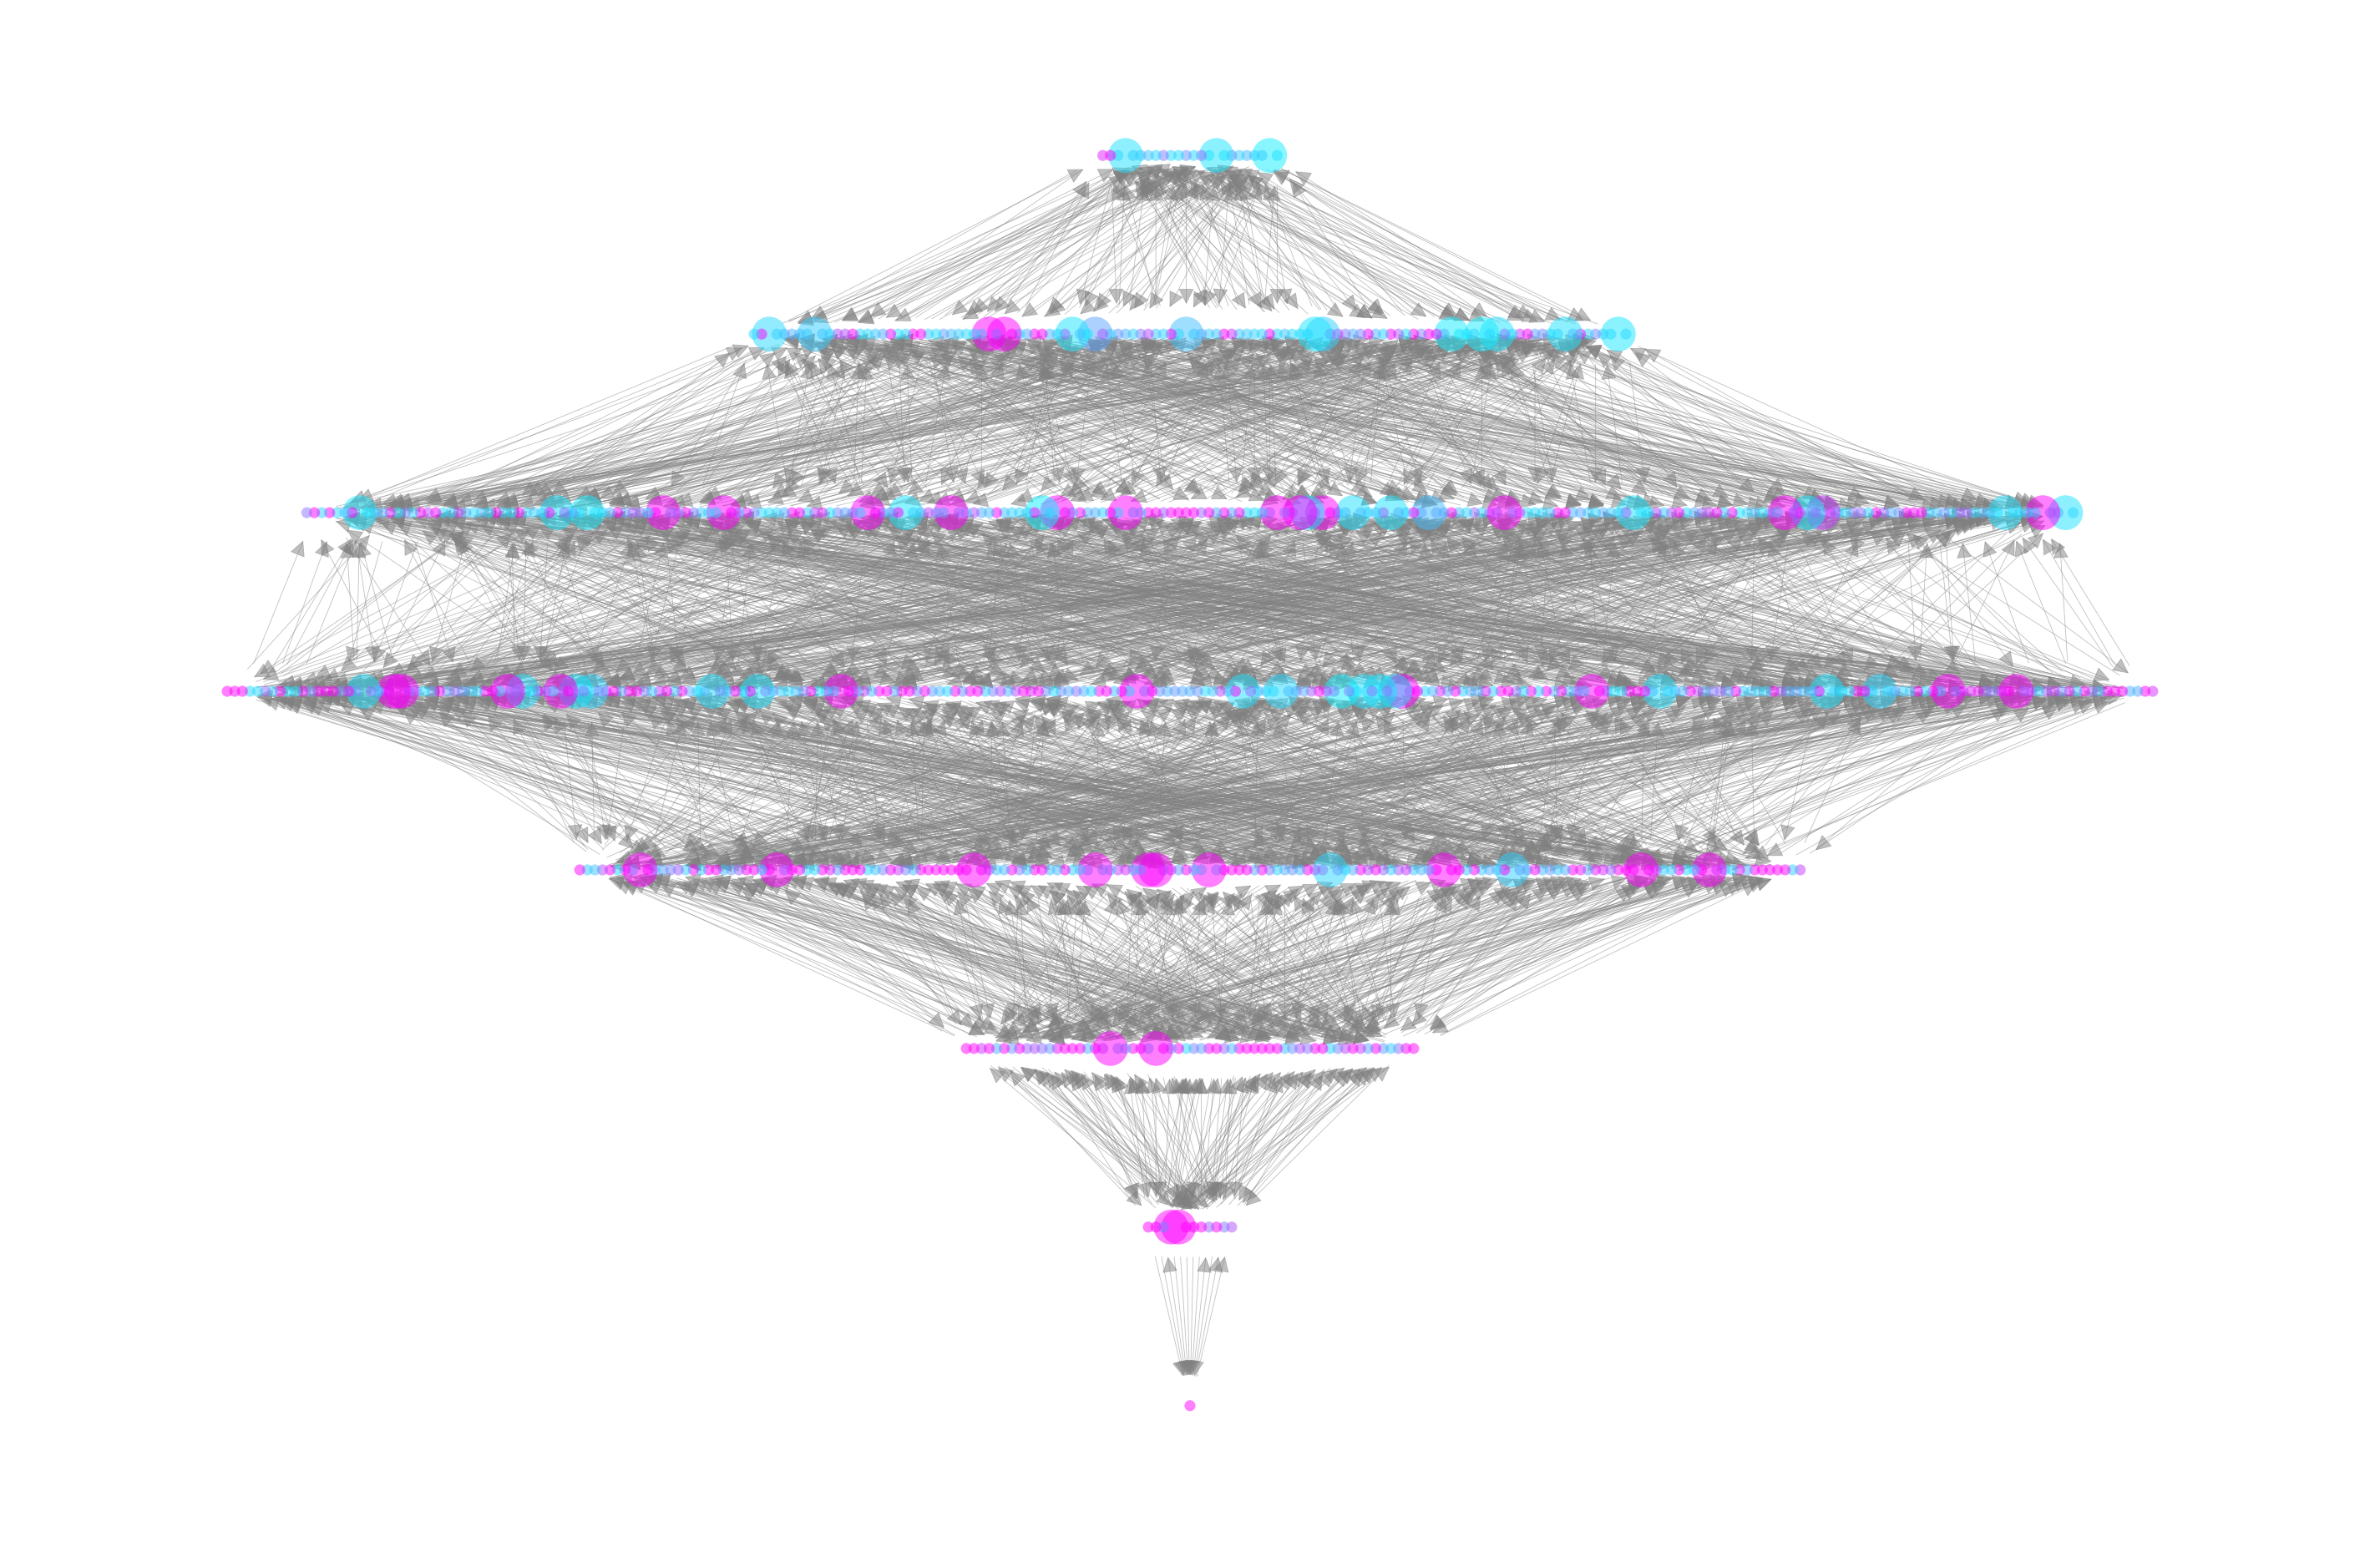

<Figure size 432x288 with 0 Axes>

In [59]:
import matplotlib as mpl
import matplotlib.cm as cm

#print(DG)
# map fitness to color map
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=mpl.cm.cool)
NodeColors = [ mapper.to_rgba(DG.nodes[v]['fit']) for v in DG.nodes ]
ndEdgeColors = []
ndSizes = []
for x in DG.nodes:
    if x in peaks:
        ndEdgeColors.append("red")
        ndSizes.append(100)
    elif x in vals:
        ndEdgeColors.append("blue")
        ndSizes.append(100)
    else:
        ndEdgeColors.append("none")
        ndSizes.append(10)

#EdgeWidth = [ abs(DG.nodes[x[0]]['fit']-DG.nodes[x[1]]['fit'])*5 for x in DG.edges()]

pos = nx.multipartite_layout(DG, align = 'horizontal')
plt.figure(figsize = (12,8), dpi=300)
ec = nx.draw_networkx_edges(DG, pos, width = 0.2, edge_color = "gray", alpha = 0.5)
nc = nx.draw_networkx_nodes(DG, pos, 
                            node_color=NodeColors, 
                            node_size=ndSizes,
                            alpha = 0.5,
                            edgecolors="none"
                            )
plt.axis('off')
plt.show()
plt.savefig("na.png")

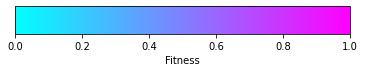

In [61]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Fitness')